- Pre-model Analysis: process and visualize data; get insights of features and target.
- Problem Definition: translate the business needs into machine learning problems; design metrics to measure model performance.
- Feature Engineering: create features which might improve model performance.
- Modeling: Model selection, feature elimination, validation, hyperparameter tuning.
- Post-model Analysis: Model performance, feature importance, actionable suggestions to busines

# Business Problem

We are an agency helping our customers purchase XoX (a made-up product) from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience. 

We are an agency helping our customers purchase XoX from various makers. Price is one of the most important things we care about. We need to estimate the price of a XoX before we recommend it to our customers. However, the estimations vary significantly with our employees' experience.

# Business Solution

Building a **Price Prediction Engine** to help consistently predict the purchase price and identify the most important features. And our model selection will be based on MAE, MSE, R2 metircs and model interpretability.

# Pre-model Analysis

### Importing libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import TransformerMixin
import category_encoders as ce #hashencoding
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.feature_extraction import FeatureHasher

### Loading the data into the data frame

In [56]:
df = pd.read_csv('../data/sales.csv')

In [57]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [58]:
rows = df.shape[0]
cols = df.shape[1]
print('There are {0:,} rows and {1:} columns'.format(rows,cols))

There are 3,197 rows and 11 columns


In [59]:
df.info() #overview of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cost           2216 non-null   object
 1   price          3186 non-null   object
 2   weight         3193 non-null   object
 3   purchase_date  3196 non-null   object
 4   product_type   3196 non-null   object
 5   product_level  3196 non-null   object
 6   maker          2373 non-null   object
 7   ingredient     2941 non-null   object
 8   height         3197 non-null   object
 9   width          3193 non-null   object
 10  depth          3193 non-null   object
dtypes: object(11)
memory usage: 274.9+ KB


<AxesSubplot: >

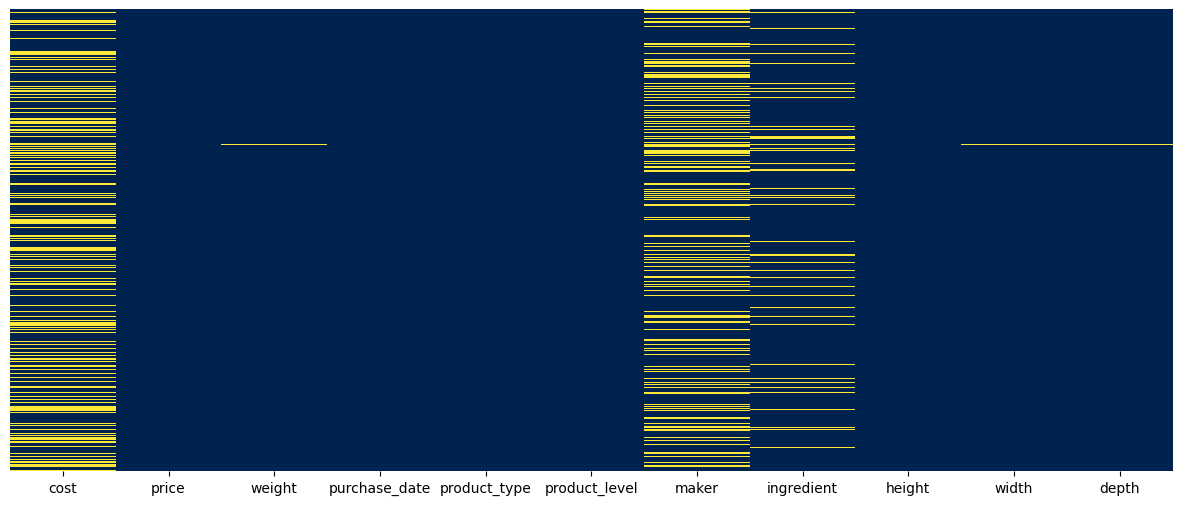

In [60]:
plt.figure(figsize=(15,6)); #check missing values
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='cividis')

Cost and maker have higher percentage of missing values

## Exploring numerical Features

### Tranform numerical data into numbers

In [61]:
# Convert cost string to numeric (unit: $)        
def cost2num(x):
    if type(x) == str:
        x = x.strip('$').strip('k')
        return float(x)*1000
    else:
        return x

# Convert weight string to numeric (unit: kg)
def weight2num(x):
    if type(x) == str:
        x = x.strip('Kg').strip().split(' Ton ')
        return float(x[0])*1000+float(x[1])
    else:
        return x

# Convert height string to numeric (unit: cm)
def height2num(x):
    if type(x) == str:
        x = x.strip('meters').strip()
        return float(x)*100
    else:
        return x        

# Convert width string to numeric (unit: cm)
def width2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x   

# Convert depth string to numeric (unit: cm)
def depth2num(x):
    if type(x) == str:
        x = x.strip('cm').strip()
        return float(x)
    else:
        return x 
    
# Convert price stirng to numeric    
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [62]:
cost = df.cost.map(cost2num)
weight = df.weight.map(weight2num)
height = df.height.map(height2num)
width = df.width.map(width2num)
depth = df.depth.map(depth2num)
price = df.price.map(price2num)

### Distribution of target varaibles: Price

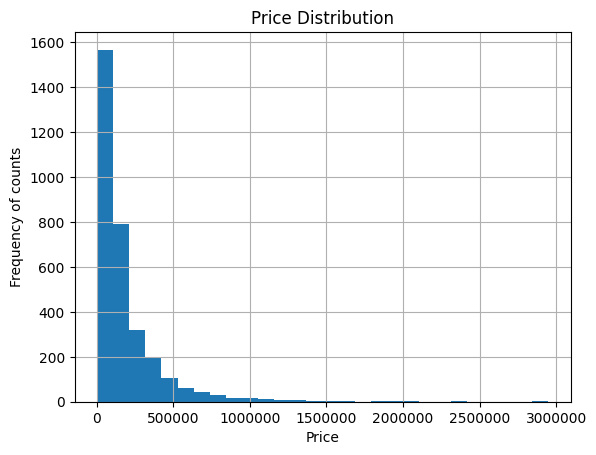

In [63]:
price.plot(kind='hist',bins = 28)
plt.xlabel('Price')
plt.ylabel('Frequency of counts')
plt.title('Price Distribution')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.grid()

You can see that price is right skewed. this was expected few products can be purchased with very expensive prices.

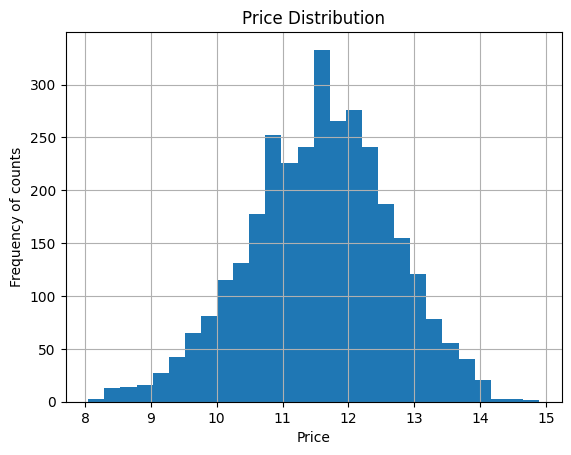

In [64]:
price.map(np.log).plot(kind='hist',bins = 28)
plt.xlabel('Price')
plt.ylabel('Frequency of counts')
plt.title('Price Distribution')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.grid()

Log the price can fix the skewness

### Plot the histogram for each numerical feature

In [65]:
df_num = pd.DataFrame({'cost':cost,'weight':weight,'height':height,'width':width,'depth':depth})

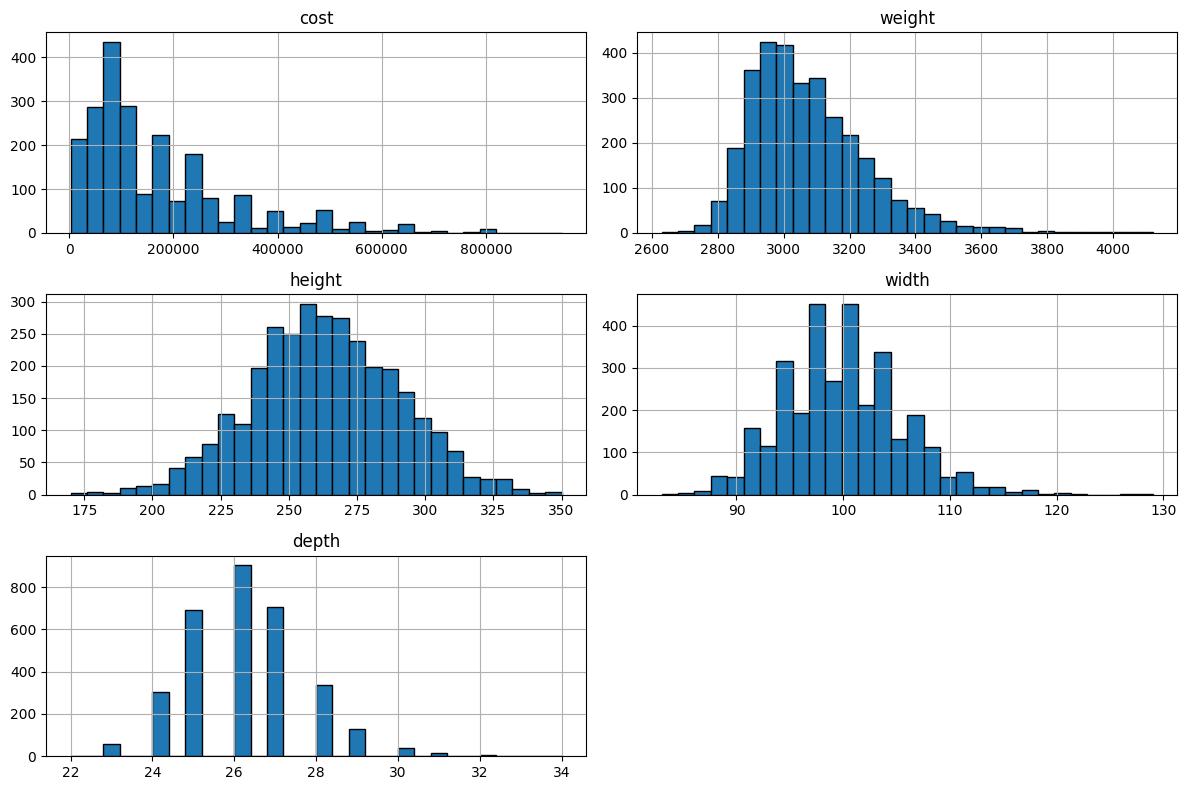

In [66]:
df_num.hist(bins=30,figsize = (12,8),edgecolor = 'Black')
plt.tight_layout()

## Exploring Categorical Features

### Ploting bar chart for categorical variables

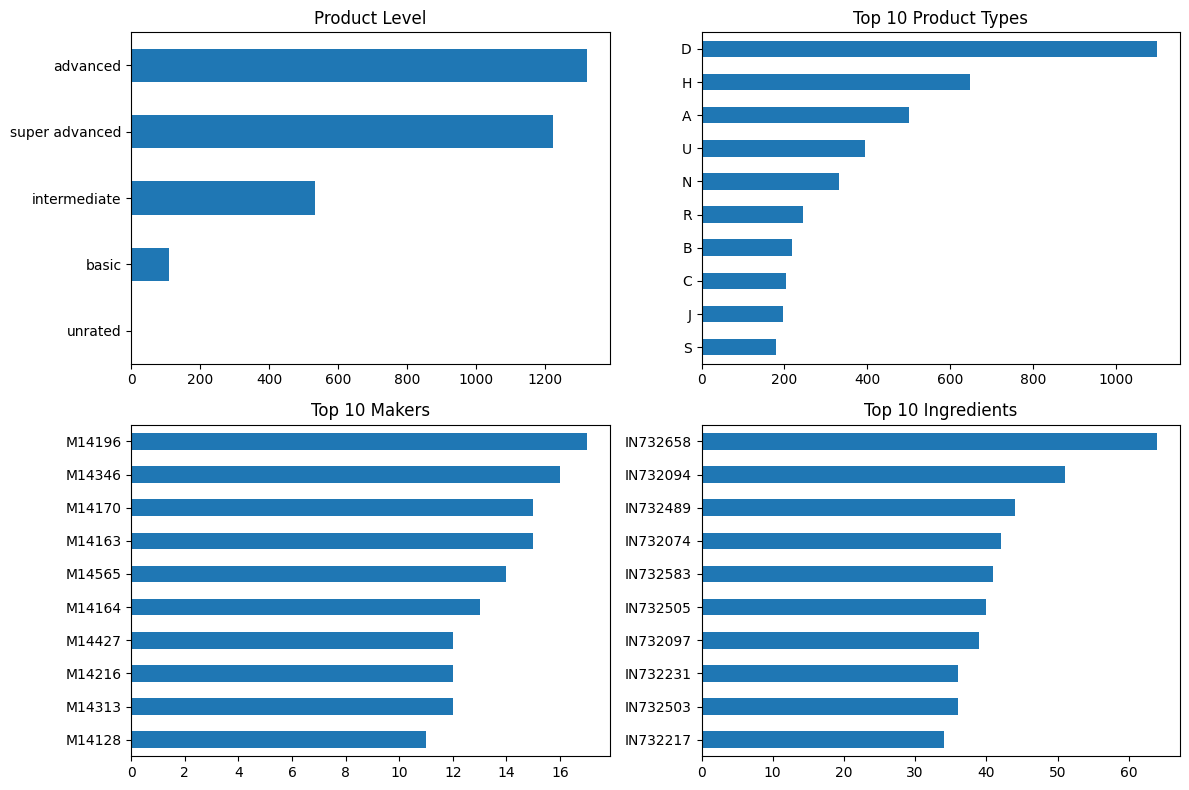

In [67]:
figure, ax = plt.subplots(2, 2,figsize=(12,8))

df.product_level.value_counts(ascending=True).plot(kind = 'barh', ax = ax[0, 0], subplots=True)
ax[0, 0].set_title("Product Level")
  
df.product_type.str.get_dummies(sep=',').sum().sort_values()[-10:].plot(kind = 'barh', ax = ax[0, 1], subplots=True)
ax[0, 1].set_title("Top 10 Product Types")
  

df.maker.str.get_dummies(sep=',').sum().sort_values()[-10:].plot(kind = 'barh', ax = ax[1, 0], subplots=True)
ax[1, 0].set_title("Top 10 Makers")
  

df.ingredient.str.get_dummies(sep=',').sum().sort_values()[-10:].plot(kind = 'barh', ax = ax[1, 1], subplots=True)
ax[1, 1].set_title("Top 10 Ingredients")

plt.tight_layout()

In [68]:
df[['product_type','product_level','maker','ingredient']].describe()

,product_type,product_level,maker,ingredient
count,3196,3196,2373,2941
unique,64,5,882,2833
top,D,advanced,M14196,IN732638
freq,485,1323,17,8


## Price relationship with numerical variables

In [69]:
# to see which numeric variables have a high correlation with purchase price

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'price'),
  Text(0, 1.5, 'cost'),
  Text(0, 2.5, 'weight'),
  Text(0, 3.5, 'height'),
  Text(0, 4.5, 'width'),
  Text(0, 5.5, 'depth')])

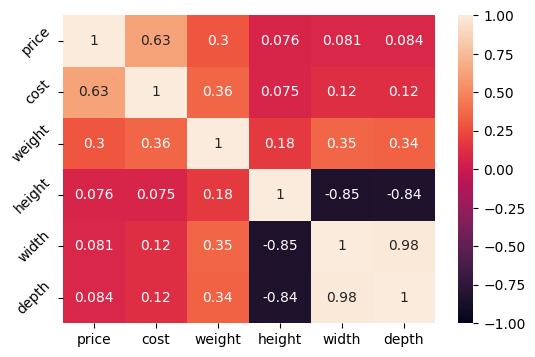

In [70]:
#add price to the df_num
df_num['price'] = price

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize =(6,4))
sns.heatmap(df_num[['price','cost','weight','height','width','depth']].corr(method='pearson'), vmin=-1, vmax=1, annot=True)
plt.yticks(rotation=45)

Cost has highest correlation with price, then weight. Height, width and depth have a low correlation with price but high collinearity with each other. will create a new feature volume = height * width * depth to replace them.

### check the new feature volume's correlation with price

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'price'),
  Text(0, 1.5, 'cost'),
  Text(0, 2.5, 'weight'),
  Text(0, 3.5, 'volume')])

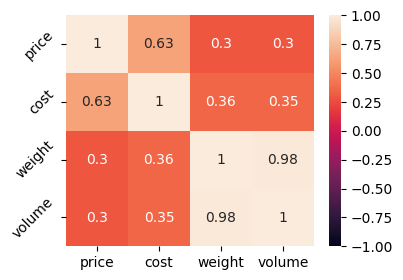

In [71]:
df_num['volume'] = 100 * df_num['height'] * df_num['width'] * df_num['depth']
fig, ax = plt.subplots(figsize =(4,3))
sns.heatmap(df_num[['price','cost','weight','volume']].corr(method='pearson'), vmin=-1, vmax=1, annot=True)
plt.yticks(rotation=45)

In [72]:
#check if there is colinearity between numeric features using VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
X = df_num[['price','cost','weight','volume']].dropna()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,price,3.066493
1,cost,3.951965
2,weight,7460.566381
3,volume,7460.890612


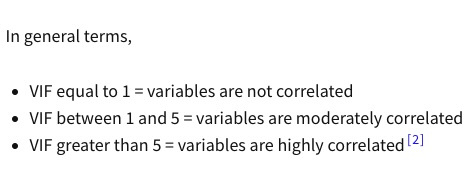

Because weight and volume have high VIF scores which indicates the high collinearity and we will keep weight and drop volume

## Price relationship with categorical variables

### Which product level has a higher price?

In [73]:
product_level_price = pd.concat([df.product_level, price], axis=1)
product_level_price.groupby('product_level')['price'].mean().sort_values(ascending=False)

product_level
basic             228899.891892
intermediate      221765.885338
advanced          213336.478030
super advanced    127551.707038
unrated             4315.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Product level vs Price')

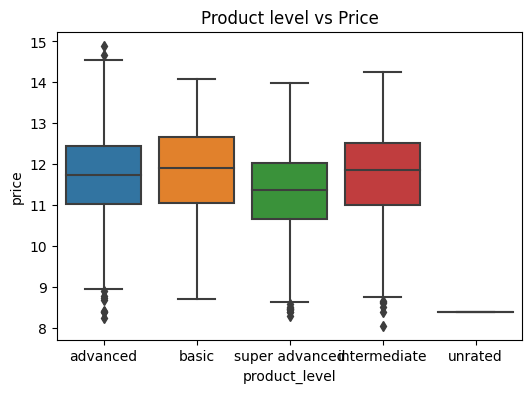

In [74]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x =df.product_level , y = price.map(np.log))
ax.set_title('Product level vs Price')

Suprisely, basic product level has the highest avg price

### Which product type has a higher price?

In [75]:
product_type_price = pd.concat([df.product_type, price], axis=1)
product_type_price.groupby('product_type')['price'].mean().sort_values(ascending=False)[:11]

product_type
K,S    638525.400000
B,A    565523.878788
K      442187.340000
Q,B    382831.230769
S,A    374140.854167
C      336423.646766
B      328898.000000
S,B    320347.800000
H,M    242050.909091
S      234537.684211
I,M    230548.166667
Name: price, dtype: float64

Seems like the combinmation of product type K and S has the highest price, and K itself ranked as thrid highest price

In [76]:
product_type_price.nunique()

product_type      64
price           3157
dtype: int64

Since product_type has only 64 categories, will use onehot encoding later to transform it.

### Which maker has a higher price?

In [77]:
maker_price = pd.concat([df.maker, price], axis=1)
maker_price.groupby('maker')['price'].mean().sort_values(ascending=False)[:11]

maker
M14275                  2124164.0
M14658                  2051887.0
M14547,M14548           1530461.0
M14405,M14585,M14710    1388871.0
M14550                  1306495.0
M14572,M14573           1261674.0
M14276                  1162886.0
M14456                  1143339.0
M14639                  1122576.0
M14883,M15011           1074844.0
M14864                  1074727.0
Name: price, dtype: float64

M14275 and M14658 are the top2 highest price maker

In [78]:
maker_price.nunique()

maker     882
price    3157
dtype: int64

Since there are too many unique values for maker, will use the hash feature encoder to transform it to numerical values

### Which ingredient has a higher price?

In [79]:
ing_price = pd.concat([df.ingredient, price], axis=1)
ing_price.groupby('ingredient')['price'].mean().sort_values(ascending=False)[:11]

ingredient
IN733878,IN733879,IN733880,IN732330,IN732085,IN732400,IN733290,IN732203,IN732676,IN733559,IN733808,IN733877,IN733881,IN733442,IN732083                                                 2945329.0
IN732688,IN732689,IN732393,IN732690,IN732328,IN732647                                                                                                                                  2358178.0
IN733576,IN732950,IN732919,IN732215,IN732128,IN733270,IN733532,IN732605                                                                                                                2051887.0
IN732691,IN732658,IN732346,IN732604,IN732146,IN732087,IN732692,IN732211,IN732094,IN732695,IN733093,IN732570,IN732350,IN732261                                                          1961055.0
IN732885,IN732486,IN732884,IN732280,IN732161,IN733749,IN732060                                                                                                                         1890150.0
IN732190,IN732065,IN7326

In [80]:
ing_price.dropna().groupby('ingredient')['price'].mean().sort_values(ascending=False)[-10:]

ingredient
IN732255,IN732167,IN732390,IN733731                                        5712.0
IN732875,IN732636,IN732435,IN732138,IN732876                               5549.0
IN733656,IN732217,IN732973,IN732605,IN732086,IN733029,IN733067,IN732384    4936.0
IN732339,IN732614,IN732454,IN732910,IN732658,IN732961,IN732902             4901.0
IN732591,IN732718,IN732137,IN733654                                        4833.0
IN732867                                                                   4653.0
IN732589,IN733018,IN732415                                                 4615.0
IN732473,IN732917,IN733034,IN732557,IN733242,IN733723,IN732617             4416.0
IN734054,IN734055,IN734056                                                 3968.0
IN733311                                                                   3730.0
Name: price, dtype: float64

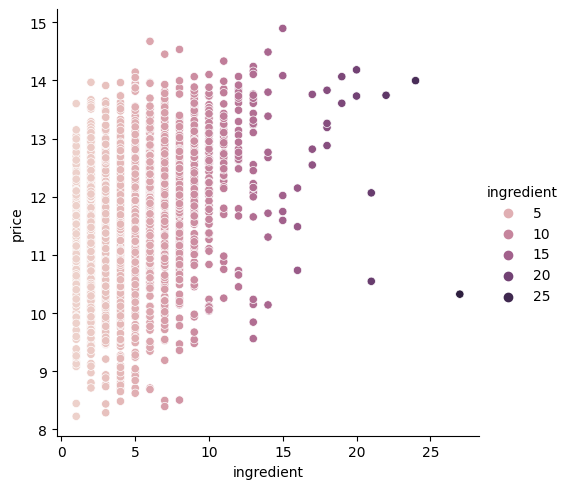

In [81]:
def igdCount(x):
    if type(x)==str:
        return len(x.split(','))

df_pri_igd=pd.DataFrame()
df_pri_igd['price']=df['price'].map(lambda x: float(x.strip('$').replace(',','')) if type(x) == str else x)
df_pri_igd['ingredient']=df.ingredient.map(igdCount)
df_pri_igd

sns.relplot(data=df_pri_igd, x="ingredient", y=df_pri_igd.price.map(np.log), hue="ingredient")

There is no easy to tell which ingredient has the highest price, but seems like the larger amount of the ingredeint, the higher the price. So we will use the count of ingredients to transform it

## Price relationship with purchase date

In [82]:
price_pd = df.price.map(price2num)
purchase_date =pd.to_datetime(df.purchase_date)
price_pd.index = purchase_date

<AxesSubplot: xlabel='purchase_date'>

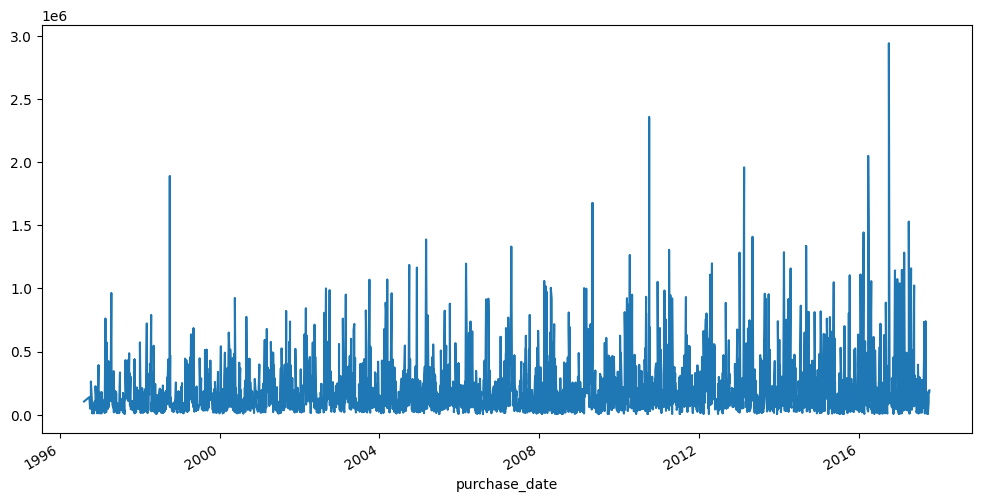

In [83]:
price_pd.dropna().plot(figsize = (12,6))

In [84]:
#convert it to year, month, weekday and day to see if there's pattern or not
price_pd = price_pd.reset_index()
price_pd['year'] = pd.to_datetime(df.purchase_date).dt.year
price_pd['month'] = pd.to_datetime(df.purchase_date).dt.month
price_pd['weekday'] = pd.to_datetime(df.purchase_date).dt.weekday
price_pd['day'] = pd.to_datetime(df.purchase_date).dt.day

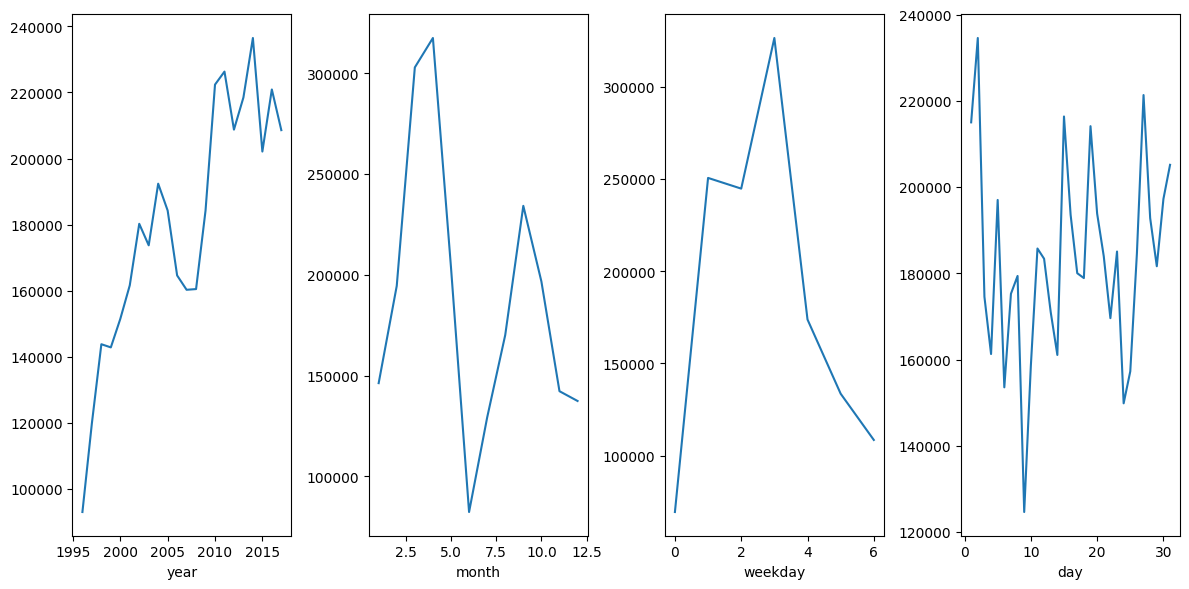

In [85]:
plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
price_pd.groupby('year').price.mean().plot()

plt.subplot(1,4,2)  
price_pd.groupby('month').price.mean().plot()
  
plt.subplot(1,4,3)  #0 is monday
price_pd.groupby('weekday').price.mean().plot()

plt.subplot(1,4,4)  
price_pd.groupby('day').price.mean().plot()

plt.tight_layout()

We could see a spike for price in 2010, jump in April with a drop in July, Thursday has the highest price and no special pattern for days

# Feature Engineer

## Missing values

In [86]:
df = pd.read_csv('../data/sales.csv')
df.isnull().mean().round(4).mul(100).sort_values(ascending=False) #missing percentage

cost             30.69
maker            25.77
ingredient        8.01
price             0.34
weight            0.13
width             0.13
depth             0.13
purchase_date     0.03
product_type      0.03
product_level     0.03
height            0.00
dtype: float64

Since cost has 31% of missing, will fill the missing values with mean value and same for wieght, and for maker, since it's a catgeorical value, will fill the null with new catagerory 'Unknown' and for ingredient, since we will use count transformer, will fill the null value with median. Will drop the missing value that less than 0.5%

In [87]:
df.dropna(subset=['price'],inplace=True)

In [88]:
df.isnull().sum()

cost             975
price              0
weight             3
purchase_date      0
product_type       0
product_level      0
maker            821
ingredient       254
height             0
width              3
depth              3
dtype: int64

### Building the numerical transformer and fit the missing value with mean

In [89]:
class Num_Transformer(TransformerMixin):

    def __init__(self): 
        self.mean = 0
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(cost2num)
        df['weight'] = X['weight'].map(weight2num)
        self.mean = df.mean()

    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(cost2num)
        df['weight'] = X['weight'].map(weight2num)
        return df.fillna(self.mean)
 
    def fit_transform(self, X, y=None):     
        self.fit(X)
        return self.transform(X)

In [90]:
nt = Num_Transformer()
nt.fit_transform(df)

,cost,weight
0,333000.000000,3090.0
1,169019.448213,3030.0
2,270000.000000,3040.0
3,169019.448213,3050.0
4,97000.000000,2970.0
...,...,...
3192,169019.448213,3000.0
3193,169019.448213,2830.0
3194,169019.448213,3080.0
3195,44000.000000,2950.0


### Building Count tranformer for ingredient and fill the missing value with median value

In [91]:
class Count_Transformer(object):
    def __init__(self):
        self.median = 0
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['ingredient']=X.ingredient.apply(self.count)
        self.median = df.median()
            
    def transform(self,X, y = None):
        df = pd.DataFrame()
        df['ingredient']=X.ingredient.apply(self.count)
        return df.fillna(self.median)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def count(self,x):
        if type(x) == str: 
            return len(x.split(','))

### Using OneHotEncoder to tranform product_type

In [92]:
cat_transformer = Pipeline(steps=[
                                  ('encoder', OneHotEncoder(handle_unknown='ignore'))])

### Using Ordinal transformer for product_level and assign values based on its avg price ranking

In [93]:
ord_transformer = ce.OrdinalEncoder(cols=['product_level'],return_df=True,
                      mapping=[{'col':'product_level', 
                                    'mapping':{'unrated':0,'basic':4,'intermediate':3,
                                               'advanced':2,'super advanced':1}}])

In [94]:
ord_transformer

OrdinalEncoder(cols=['product_level'],
               mapping=[{'col': 'product_level',
                         'mapping': {'advanced': 2, 'basic': 4,
                                     'intermediate': 3, 'super advanced': 1,
                                     'unrated': 0}}])

### Using FeatureHasher transformer for maker and fill null value with **'Unkown'**

In [95]:
hash_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                                    ('ft',FeatureHasher(n_features=9, input_type='string'))])

# Modeling

In [96]:
#data split
df['year'] = pd.to_datetime(df.purchase_date).dt.year

train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

print('train dataset percentage: {0:.2f}'.format(len(df[df.year<2015])/len(df)) )

train dataset percentage: 0.87


In [97]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [98]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

### Building preprocessor pipeline

In [99]:
num_transformer = Pipeline(steps=[('nt', Num_Transformer())
                                       ,('scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps=[
                                  ('encoder', OneHotEncoder(handle_unknown='ignore'))])

count_transformer = Pipeline(steps=[('ct',Count_Transformer())])

ord_transformer = ce.OrdinalEncoder(cols=['product_level'],return_df=True,
                      mapping=[{'col':'product_level', 
                                    'mapping':{'unrated':0,'basic':4,'intermediate':3,
                                               'advanced':2,'super advanced':1}}])

hash_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                                    ('ft',FeatureHasher(n_features=9, input_type='string'))])

preprocessor = ColumnTransformer(
               [('num', num_transformer,['cost','weight']),
                ('ct',  count_transformer,['ingredient']),
                ('ord', ord_transformer,['product_level']),
                ('cat', cat_transformer,['product_type']),
                ('ft',hash_transformer,['maker'])
               ])

In [100]:
preprocessor_num = ColumnTransformer(
               [('num', num_transformer,['cost','weight']),
               ])

In [104]:
pd.DataFrame(preprocessor.fit_transform(df))

,0
0,"(0, 0)\t0.3503184713375796\n (0, 1)\t0.3087..."
1,"(0, 0)\t0.1762414524559215\n (0, 1)\t0.2684..."
2,"(0, 0)\t0.28343949044585987\n (0, 1)\t0.275..."
3,"(0, 0)\t0.1762414524559215\n (0, 1)\t0.2818..."
4,"(0, 0)\t0.09978768577494691\n (0, 1)\t0.228..."
...,...
3181,"(0, 0)\t0.1762414524559215\n (0, 1)\t0.2483..."
3182,"(0, 0)\t0.1762414524559215\n (0, 1)\t0.1342..."
3183,"(0, 0)\t0.1762414524559215\n (0, 1)\t0.3020..."
3184,"(0, 0)\t0.0435244161358811\n (0, 1)\t0.2147..."


### Seting up regression models

In [105]:
# linear regression
model_lr = Pipeline(steps=
            [('preprocessor', preprocessor),
              ('lr', LinearRegression())])
model_lr.fit(X_train, y_train)

#linear regression with numerical variables only
model_lr_num = Pipeline(steps=
            [('preprocessor_num', preprocessor_num),
              ('lr', LinearRegression())])
model_lr_num.fit(X_train, y_train)

#random forest
model_rfr = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('rfr', RandomForestRegressor(random_state = 1200))])
model_rfr.fit(X_train, y_train)

#GradientBoosting
model_gbr = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('gbr', GradientBoostingRegressor(random_state = 1200))])
model_gbr.fit(X_train, y_train)

#XGBoost
model_xgbr = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('xgbr', XGBRegressor(random_state = 1200))])
model_xgbr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nt',
                                                                   <__main__.Num_Transformer object at 0x00000022BE5DE3D0>),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cost', 'weight']),
                                                 ('ct',
                                                  Pipeline(steps=[('ct',
                                                                   <__main__.Count_Transformer object at 0x00000022BE574D30>)]),
                                                  ['ingredient']),
                                                 ('ord',
                                                  OrdinalEncoder(cols=['product_level'],
                                                                 mapping=[...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=1200, ...))])

### Set up function for GridSearchCV to return best resutls

In [106]:
def best_params(model, X, y, param_grid):
    gs = GridSearchCV(model,param_grid,cv=5,n_jobs=-1,scoring = make_scorer(mean_squared_error,greater_is_better=False))
    res = gs.fit(X, y)
    print(res.best_params_)

In [107]:
#RandomForest hyperparameters
rfr_gs = {'rfr__n_estimators': [50,100,150],
          'rfr__min_samples_split': [4,6,8,10],
          'rfr__min_samples_leaf': [4,6,8],
          'rfr__max_depth': [2,4,6],
          }
best_params(model_rfr, X_train, y_train, rfr_gs)

{'rfr__max_depth': 6, 'rfr__min_samples_leaf': 6, 'rfr__min_samples_split': 4, 'rfr__n_estimators': 50}


In [54]:
#GradientBoosting hyperparameters
gbr_gs = {'gbr__learning_rate': [0.05,0.1], 
          'gbr__n_estimators': [50, 100, 150], 
          'gbr__max_depth': [2, 3, 4,5], 
          'gbr__min_samples_leaf': range(30, 150, 30), 
          'gbr__min_samples_split': [1, 2, 4]}
best_params(model_gbr, X_train, y_train, gbr_gs)

NameError: name 'model_gbr' is not defined

In [ ]:
#XGBoost Parameters
xgbr_gs    = {'xgbr__gamma': [0.0, 0.1, 0.2, 0.3], 
              'xgbr__learning_rate': [0.05, 0.1], 
              'xgbr__n_estimators': [100, 300, 500], 
              'xgbr__max_depth': [3, 5, 10], 
              'xgbr__lambda': [0.5, 1, 5], 
              'xgbr__min_child_weight': [3, 5, 7]}
best_params(model_xgbr, X_train, y_train, xgbr_gs)

### Fit the model with best parameters

In [64]:
model_rfr_bp = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('rfr', RandomForestRegressor(n_estimators=50, min_samples_split=8, 
                min_samples_leaf=6, max_depth=12, random_state=1200))])
model_rfr_bp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nt',
                                                                   <__main__.Num_Transformer object at 0x000000582EAD7EE0>),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cost', 'weight']),
                                                 ('ct',
                                                  Pipeline(steps=[('ct',
                                                                   <__main__.Count_Transformer object at 0x000000582EAD78E0>)]),
                                                  ['ingredient']),
                                                 ('ord',
                                                  OrdinalEncoder(cols=['product_level'],
                                                                 mapping=[...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['product_type']),
                                                 ('ft',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ft',
                                                                   FeatureHasher(input_type='string',
                                                                                 n_features=9))]),
                                                  ['maker'])])),
                ('rfr',
                 RandomForestRegressor(max_depth=12, min_samples_leaf=6,
                                       min_samples_split=8, n_estimators=50,
                                       random_state=1200))])

In [65]:
model_gbr_bp = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('gbr', GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, 
                        max_depth=2,min_samples_leaf=30,min_samples_split=2, 
                         random_state=1200))])
model_gbr_bp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nt',
                                                                   <__main__.Num_Transformer object at 0x000000582EAD7EE0>),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cost', 'weight']),
                                                 ('ct',
                                                  Pipeline(steps=[('ct',
                                                                   <__main__.Count_Transformer object at 0x000000582EAD78E0>)]),
                                                  ['ingredient']),
                                                 ('ord',
                                                  OrdinalEncoder(cols=['product_level'],
                                                                 mapping=[...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['product_type']),
                                                 ('ft',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ft',
                                                                   FeatureHasher(input_type='string',
                                                                                 n_features=9))]),
                                                  ['maker'])])),
                ('gbr',
                 GradientBoostingRegressor(max_depth=2, min_samples_leaf=30,
                                           n_estimators=150,
                                           random_state=1200))])

In [66]:
model_xgbr_bp = Pipeline(steps=
            [('preprocessor', preprocessor),
             ('xgbr', XGBRegressor(learning_rate = 0.05,n_estimators=100,max_depth = 3, gamma = 0,
                                   min_child_weight = 7,random_state = 1200))])
model_xgbr_bp.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nt',
                                                                   <__main__.Num_Transformer object at 0x000000582EAD7EE0>),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['cost', 'weight']),
                                                 ('ct',
                                                  Pipeline(steps=[('ct',
                                                                   <__main__.Count_Transformer object at 0x000000582EAD78E0>)]),
                                                  ['ingredient']),
                                                 ('ord',
                                                  OrdinalEncoder(cols=['product_level'],
                                                                 mapping=[...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=7,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=1200, ...))])

# Post-model Analysis

### Model performance measurement
For regression models, MAE, MSE, R2 are mainly used to evaluate the model performance, and best model then will be selected.

• MAE: Mean Absolute Error. It measures the average absolute magnitude between the actual values and the predicted values. In general, the lower the MAE, the better the model predicts.

• MSE: Mean Squared Error. It measures the average of the squared difference between the actual value and predicted values. The lower the MSE, the higher the accuracy of the regression model.

• R2: proportion of variance in the dependent variable (target) that can be explained by the independent variable (features). R2 score is no greater than 1 and the higher R2 the better model performance. A negative R2 score suggests that the model performance is worse than mean value prediction, and R2 score of 1 indicates a perfect prediction.

In [67]:
def model_loss(name, model, X_train, y_train, X_test, y_test, graph=1):
    
    print('Model performance for: ', name)
    
    def calculate_loss(model, X, y):
        pred = model.predict(X)
        mae = mean_absolute_error(y, pred)
        mse = mean_squared_error(y, pred)
        r2 = r2_score(y, pred)
        return pred, mae, mse, r2
    
    y_train_pred, mae_train, mse_train, r2_train = calculate_loss(
        model, X_train, y_train)
    print(f'training MAE: {mae_train:.2e}')
    print(f'training MSE: {mse_train:.2e}')
    print(f'training R2: {r2_train:.3f}')
    print()
    
    y_test_pred, mae_test, mse_test, r2_test = calculate_loss(
        model, X_test, y_test
    )
    print(f'testing MAE: {mae_test:.2e}')
    print(f'testing MSE: {mse_test:.2e}')
    print(f'testing R2: {r2_test:.3f}')

    if graph == 0:
        return 

    elif graph == 1:
        plt.figure(figsize = (5,4), dpi = 100)
        plt.scatter(y_train, y_train_pred, s=15, alpha =0.3,label='train')
        plt.scatter(y_test, y_test_pred,s=15, alpha =0.3,label='test')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.legend(loc='best')
    
        plt.tight_layout()
        plt.show()

Model performance for:  Linear Regression
training MAE: 1.06e+05
training MSE: 2.42e+10
training R2: 0.433

testing MAE: 1.32e+05
testing MSE: 4.68e+10
testing R2: 0.457


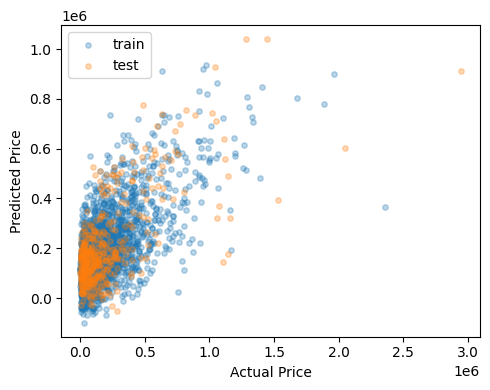

In [68]:
Linear_loss = model_loss('Linear Regression', model_lr, X_train, y_train, X_test, y_test)

Model performance for:  Linear Regression
training MAE: 1.14e+05
training MSE: 2.87e+10
training R2: 0.326

testing MAE: 1.43e+05
testing MSE: 5.59e+10
testing R2: 0.352


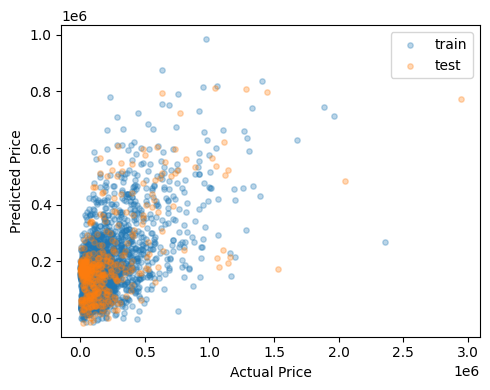

In [69]:
Linear_loss_num = model_loss('Linear Regression', model_lr_num, X_train, y_train, X_test, y_test)

Model performance for:  Random Forest
training MAE: 8.13e+04
training MSE: 1.63e+10
training R2: 0.617

testing MAE: 1.14e+05
testing MSE: 4.38e+10
testing R2: 0.492


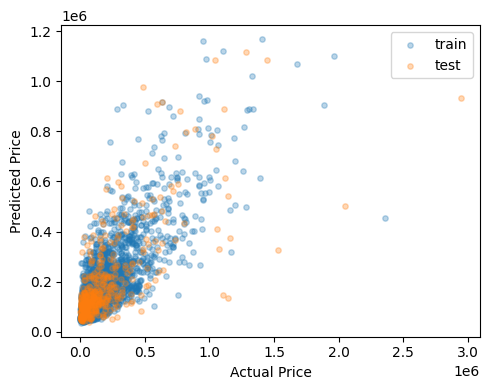

In [70]:
Random_Forest_loss=model_loss('Random Forest', model_rfr_bp, X_train, y_train, X_test, y_test)

Model performance for:  Gardient Boosting
training MAE: 9.23e+04
training MSE: 2.00e+10
training R2: 0.530

testing MAE: 1.20e+05
testing MSE: 4.58e+10
testing R2: 0.469


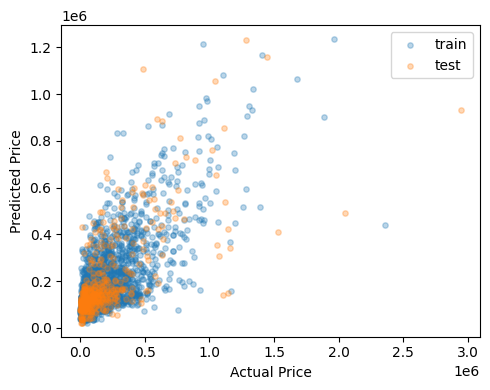

In [71]:
Gradient_Boosting_loss=model_loss('Gardient Boosting', model_gbr_bp, X_train, y_train, X_test, y_test)

Model performance for:  XGBoost
training MAE: 9.15e+04
training MSE: 1.91e+10
training R2: 0.552

testing MAE: 1.17e+05
testing MSE: 4.41e+10
testing R2: 0.488


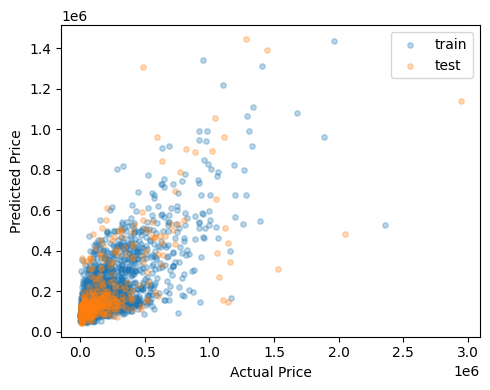

In [72]:
Xgboost_loss=model_loss('XGBoost', model_xgbr_bp, X_train, y_train, X_test, y_test)

In [73]:
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

Linear_loss = [mean_absolute_error(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred),r2_score(y_train, y_train_pred),
                     mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred)]

y_train_pred = model_lr_num.predict(X_train)
y_test_pred = model_lr_num.predict(X_test)
Linear_loss_num = [mean_absolute_error(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred),r2_score(y_train, y_train_pred),
                      mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred)]

y_train_pred = model_rfr_bp.predict(X_train)
y_test_pred = model_rfr_bp.predict(X_test)
Random_Forest_loss = [mean_absolute_error(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred),r2_score(y_train, y_train_pred),
                      mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred)]

y_train_pred = model_gbr_bp.predict(X_train)
y_test_pred = model_gbr_bp.predict(X_test)
Gradient_Boosting_loss = [mean_absolute_error(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred),r2_score(y_train, y_train_pred),mean_absolute_error(y_test, y_test_pred), 
                          mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred)]


y_train_pred = model_xgbr_bp.predict(X_train)
y_test_pred = model_xgbr_bp.predict(X_test)
Xgboost_loss = [mean_absolute_error(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred),r2_score(y_train, y_train_pred),
                      mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred),r2_score(y_test, y_test_pred)]

df = pd.DataFrame({
                    'Linear': Linear_loss,
                    'Linear_num': Linear_loss_num,
                    'RF':Random_Forest_loss,
                    'GBR':Gradient_Boosting_loss,
                    'XgBR': Xgboost_loss
                  })
df.index =['train MAE', 'train MSE', 'train R^2','test MAE', 'test MSE', 'test R^2']


<AxesSubplot: title={'center': 'MAE Comparision'}>

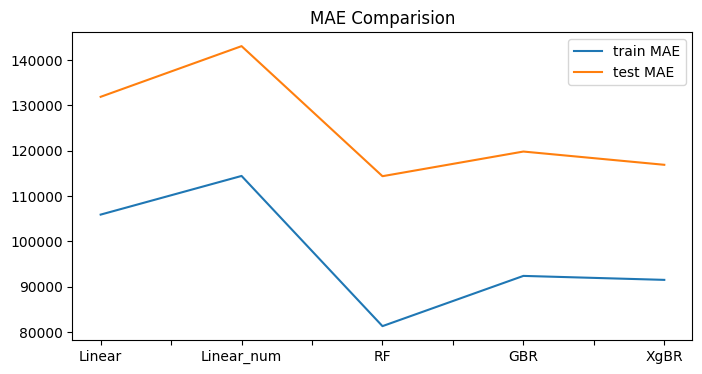

In [74]:
df.transpose()[['train MAE','test MAE']].plot(title = 'MAE Comparision', figsize = (8,4))

<AxesSubplot: title={'center': 'MSE Comparison'}>

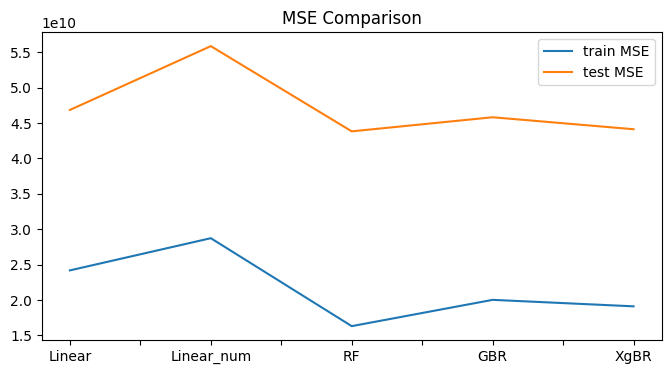

In [75]:
df.transpose()[['train MSE','test MSE']].plot(title = 'MSE Comparison', figsize = (8,4))

<AxesSubplot: title={'center': 'R^2 Comparison'}>

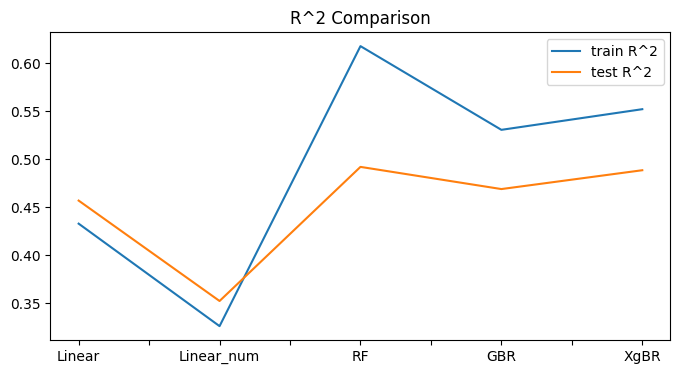

In [76]:
df.transpose()[['train R^2','test R^2']].plot(title = 'R^2 Comparison', figsize = (8,4))

Since Random Forest model has the highest test R2, we will choose it as our final prediction model

### Identify the most important features

Text(0.5, 1.0, 'Feature Importance of Random Forest')

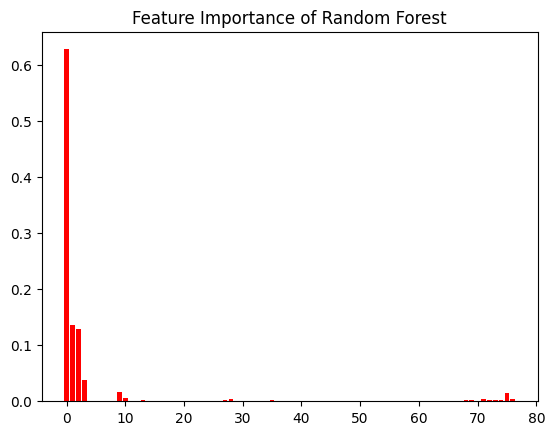

In [77]:
importances_rfr = model_rfr_bp.steps[1][1].feature_importances_
plt.bar(range(len(importances_rfr)), importances_rfr, color="r", align = "center")
plt.title('Feature Importance of Random Forest')

Text(0.5, 1.0, 'Feature Importance of GrandientBoosting')

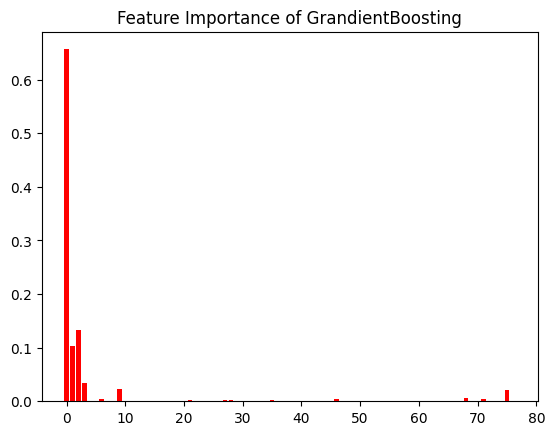

In [78]:
importances = model_gbr_bp.steps[1][1].feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.title('Feature Importance of GrandientBoosting')

Text(0.5, 1.0, 'Feature Importance of XGBoost')

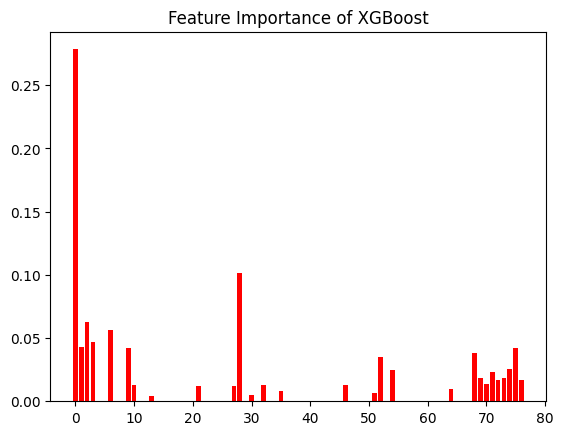

In [79]:
importances = model_xgbr_bp.steps[1][1].feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.title('Feature Importance of XGBoost')

In [83]:
#since we have ~80 variables, and only first 4 have highest importance scores, so we will show top 4 features of random forest
top_importances_rfr4 = importances_rfr[:4]
top_importances_rfr4

array([0.62780476, 0.13527314, 0.12963274, 0.03719209])

([<matplotlib.axis.XTick at 0x58320d9310>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'ingredient_count'),
  Text(3, 0, 'product_level_ord')])

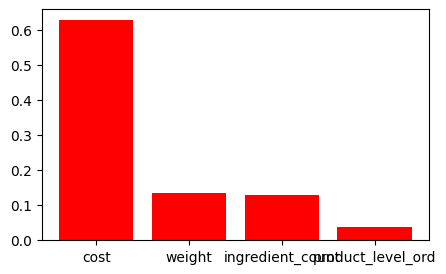

In [89]:
plt.figure(figsize=(5,3))
plt.bar(range(len(top_importances_rfr4)), top_importances_rfr4, color="r", align = "center")
plt.xticks(range(len(top_importances_rfr4)), ['cost', 'weight', 'ingredient_count', 'product_level_ord'])

# Summary
Suggestions to business

We built the price prediction engine with deffrent models: linear regression model, Random Forest Model, Gredient Boosting and Xgboost regression model. After tuning hyperparameters, MAE, MSE and R2 are used to measure model performance. Also, feature_importance is analyzed in each model to demonstrate the interpretability of each model.
1. Random Forest regression model got the hightest test_R2 score, and the lowest MAE and MSE score.
2. The first four features in Random Forest and Gredient boosting regression models can explain most part of the 
Finally, we choosed the 
Cost is most important feature when deciding price, and weight, count of ingredient and product level also have some impact on the price.

Cost is the most related feature in our model, so if our customer wants to purchase XoX cheaper, as long as they know the cost, they could probably negotiate better.

Weight is the second most related feature. Considering the seasonality we observed earlier in our report and the actual lead time, our customer can purchase the product during June, and the lighter the product the cheaper the price could be. Since the weight is super heavy, we could suggest our customer to seek various ways to reduce cost of transportation.

We also see product type are somewhat related to the price too. If we can find out which product types contribute more for the product, and suggest our customer to keep track of the cost for those product type as reference for future purchase.

Also, if model interpretability is more important to the customer, we can also provide this model as an option.